##Objetivo do Trabalho

Este trabalho tem como objetivo desenvolver um pipeline completo de dados em nuvem utilizando a plataforma **Databricks**. A proposta abrange todas as etapas essenciais de engenharia de dados: **extração, transformação, modelagem, carga e análise**. 

O dataset utilizado foi obtido do portal de dados abertos da Prefeitura de Belo Horizonte (PBH) e trata da **relação de ocorrências de acidentes de trânsito com vítima** do ano 2021, oferecendo uma oportunidade rica de análise para promover a segurança viária e a tomada de decisões baseadas em dados.

---

### Perguntas Iniciais

Durante a fase de planejamento, foram definidas perguntas norteadoras baseadas em hipóteses de interesse público e relevância analítica:

- **Qual a distribuição temporal dos acidentes (horário, dia da semana, meses)?**
- **Quais são os tipos de acidentes mais frequentes e mais graves?**
- **Como fatores como condições climáticas e tipo de pavimento influenciam os acidentes?**
- **Existem trechos rodoviários com incidência significativamente maior de acidentes?**

Essas questões buscavam um entendimento amplo sobre o comportamento dos acidentes em diferentes dimensões temporais, espaciais e estruturais.

---

### Perguntas Analisadas na Versão Final

Com base na **disponibilidade real dos dados**, algumas perguntas foram ajustadas ou refinadas para garantir **viabilidade técnica** e **qualidade nas análises**. As perguntas finais, mais específicas e bem adaptadas ao escopo dos dados disponíveis, foram:

1. **Qual a distribuição temporal dos acidentes (hora, dia da semana, tipo_dia)?**
2. **Quais são os tipos de acidentes mais frequentes e que têm maior taxa de mortalidade?**
3. **Como fatores como condições climáticas e tipo de pavimento influenciam os acidentes?**
4. **Existe região com incidência significativamente maior de acidentes?**
5. **Quais combinações de fatores estão mais associadas a vítimas fatais?**
6. **Qual a proporção de acidentes com vítimas que ocorrem em locais não sinalizados?**

---

### 🔄 Por que as perguntas mudaram?

A mudança ocorreu principalmente por dois motivos:

- **Limitações no dataset original:** Nem todos os atributos esperados (como dados detalhados de trechos rodoviários ou condições meteorológicas completas) estavam disponíveis ou com qualidade suficiente.
- **Possibilidades identificadas na modelagem:** Com o avanço do processo de transformação e exploração dos dados, surgiram novas oportunidades de análise mais realistas e úteis, como o cruzamento entre **sinalização, tipo de acidente e vítimas fatais**.

Esses ajustes permitiram **aproveitar ao máximo o potencial dos dados disponíveis**, mantendo a relevância prática das análises e respeitando os princípios de uma abordagem orientada por dados.

---

In [0]:
# PySpark Functions (organizados por categoria)
from pyspark.sql.functions import (
    col, when, lit, isnull, round,
    mean, stddev, min, max, count,
    to_timestamp, to_date, date_format,
    year, month, dayofmonth, hour,
    weekofyear, dayofweek, quarter,
    current_timestamp
)

# PySpark Types
from pyspark.sql.types import *

# PySpark Exceptions
from pyspark.sql.utils import AnalysisException

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades
from IPython.display import display
import numpy as np
import pandas as pd

## 1. Busca de Dados

- **Fonte**: [Portal de Dados Abertos - Prefeitura de Belo Horizonte (PBH)](https://dados.gov.br/dados/conjuntos-dados/relacao-de-ocorrencias-de-acidentes-de-transito-com-vitima)
- **Dataset**: si-bol-2021
- **Formato**: CSV
- **Ferramenta utilizada**: Databricks (Apache Spark)
- **Licença:** [Open Database License (ODbL)](https://opendatacommons.org/licenses/odbl/)

A licença ODbL permite **usar, modificar e compartilhar** os dados, desde que seja dada a devida atribuição e que os dados derivados também sejam compartilhados sob a mesma licença. Isso garante transparência e promove o reuso dos dados em iniciativas públicas e acadêmicas.

### Processo de Upload do Arquivo CSV

O arquivo `si_bol_2021.csv` foi carregado manualmente via interface gráfica do Databricks, utilizando os seguintes passos:

1. Acesso ao menu lateral esquerdo no ambiente Databricks.  
2. Caminho: **Data** → **Upload File** → **DBFS** → `/FileStore/tables/`  
3. Seleção e envio do arquivo CSV diretamente do computador local.

O caminho resultante para o arquivo foi:  
`/FileStore/tables/si_bol_2021.csv`

### Leitura do Arquivo com Spark

O código abaixo realiza a leitura do arquivo CSV para um DataFrame do Spark:

In [0]:
# 1. Carregar os dados 

# Utiliza o Spark para ler o arquivo CSV 
df = spark.read.csv(
    "/FileStore/tables/si_bol_2021.csv", 
    header=True,
    sep=";",
    inferSchema=True
    ,encoding="ISO-8859-1"
)
df.show(5)

+------------------+------------------+----------------+--------------+--------------------+----------+---------------+--------------+---------------+-------------+---------------+---------------+-----------------+---------------------+-------------+-------------+---------------+---------------------+----------+--------------+--------------------+-----------------+---------------------+
|    NUMERO_BOLETIM| DATA HORA_BOLETIM|   DATA_INCLUSAO| TIPO_ACIDENTE|  DESC_TIPO_ACIDENTE| COD_TEMPO|     DESC_TEMPO| COD_PAVIMENTO|      PAVIMENTO| COD_REGIONAL|  DESC_REGIONAL| ORIGEM_BOLETIM| LOCAL_SINALIZADO| VELOCIDADE_PERMITIDA| COORDENADA_X| COORDENADA_Y| HORA_INFORMADA| INDICADOR_FATALIDADE| VALOR_UPS| DESCRIÇÃO_UPS| DATA_ALTERACAO_SMSA| VALOR_UPS_ANTIGA| DESCRIÇÃO_UPS_ANTIGA|
+------------------+------------------+----------------+--------------+--------------------+----------+---------------+--------------+---------------+-------------+---------------+---------------+-----------------+------

%md
#### 1.2 Transformações

- **Padronizar os nomes das colunas:** remover espaços e acentuação para facilitar o uso no pipeline.
- **Tornar os nomes mais descritivos:** visando melhor compreensão sem necessidade de consultar o dicionário de dados constantemente.
- **Identificar colunas relevantes para a análise** e limpar aquelas que não seriam utilizadas inicialmente.
- **Conversão de tipos** (como data e hora)

---

In [0]:
# Transformações 
df_clean = (df
    # Renomear colunas
    .select(
        col(" NUMERO_BOLETIM").alias("numero_boletim"),
        col(" DATA HORA_BOLETIM").alias("data_hora_boletim_raw"),
        col(" DATA_INCLUSAO").alias("data_inclusao_raw"),
        col(" TIPO_ACIDENTE").alias("tipo_acidente"),
        col(" DESC_TIPO_ACIDENTE").alias("descricao_tipo_acidente"),
        col(" COD_TEMPO").alias("codigo_tempo"),
        col(" DESC_TEMPO").alias("descricao_tempo"),
        col(" COD_PAVIMENTO").alias("codigo_pavimento"),
        col(" PAVIMENTO").alias("pavimento"),
        col(" COD_REGIONAL").alias("codigo_regional"),
        col(" DESC_REGIONAL").alias("descricao_regional"),
        col(" ORIGEM_BOLETIM").alias("origem_boletim"),
        col(" LOCAL_SINALIZADO").alias("local_sinalizado"),
        col(" VELOCIDADE_PERMITIDA").alias("velocidade_permitida"),
        col(" COORDENADA_X").alias("coordenada_x"),
        col(" COORDENADA_Y").alias("coordenada_y"),
        col(" HORA_INFORMADA").alias("hora_informada"),
        col(" INDICADOR_FATALIDADE").alias("indicador_fatalidade"),
        col(" VALOR_UPS").alias("valor_ups"),
        col(" DESCRIÇÃO_UPS").alias("descricao_ups"),
        col(" DATA_ALTERACAO_SMSA").alias("data_alteracao_smsa_raw"),
        col(" VALOR_UPS_ANTIGA").alias("valor_ups_antiga"),
        col(" DESCRIÇÃO_UPS_ANTIGA").alias("descricao_ups_antiga")
    )
    
    # Conversão de datas com tratamento de erros
    .withColumn("data_hora_boletim", 
               when(col("data_hora_boletim_raw").isNotNull(),
                    to_timestamp(col("data_hora_boletim_raw"), "dd/MM/yyyy HH:mm"))
               .otherwise(lit(None)))
    .withColumn("data_boletim", 
               to_date(col("data_hora_boletim")))
    .withColumn("hora_boletim",
               date_format(col("data_hora_boletim"), "HH:mm"))
    .withColumn("data_inclusao", 
               when(col("data_inclusao_raw").isNotNull(),
                    to_timestamp(col("data_inclusao_raw"), "dd/MM/yyyy HH:mm"))
               .otherwise(lit(None)))
    
    # Flags binárias
    .withColumn("fatal", 
               when(col("indicador_fatalidade") == "SIM", 1).otherwise(0))
    .withColumn("sinalizado", 
               when(col("local_sinalizado") == "SIM", 1).otherwise(0))
    
    # Tratamento de valores
    .withColumn("velocidade_permitida", 
               when(col("velocidade_permitida") == 0, None)
               .otherwise(col("velocidade_permitida")))
    
    # Remoção de colunas temporárias
    .drop("data_hora_boletim_raw", "data_inclusao_raw", "data_alteracao_smsa_raw")
)

### 2. Coleta e Armazenamento na Nuvem

Após o processo de transformação e limpeza dos dados, seguimos para a etapa de coleta e persistência definitiva no ambiente de nuvem (Databricks). Essa fase garante que os dados estejam disponíveis para consultas eficientes e seguras, utilizando o formato Delta Lake.

---

##### Armazenamento dos Dados - `df_clean`

A variável `df_clean` representa o DataFrame final com as colunas renomeadas, estruturadas e prontas para análise. Para garantir a persistência e integridade desses dados, foi utilizada a tecnologia **Delta Lake** no ambiente Databricks.

Essa tecnologia permite:
- Armazenamento transacional;
- Suporte a versionamento;
- Atualizações de schema;
- Consultas rápidas por meio de otimizações nativas.

A tabela foi armazenada sob o nome `acidentes_prf_2021_clean`, com substituição completa dos dados caso a tabela já existisse anteriormente.

##### Criação de View Lógica - `acidentes_2021`

Foi criada uma view chamada `acidentes_2021` a partir da tabela `acidentes_prf_2021_clean`. Essa view facilita o acesso e reutilização dos dados em análises SQL sem alterar a tabela original.

As views são importantes para:
- Reduzir complexidade de nomes;
- Padronizar consultas;
- Abstrair transformações futuras.

##### Verificação Final da Persistência - `acidentes_prf_2021_clean`

Após a criação da tabela Delta, foi realizada uma verificação para garantir que:
- A tabela foi criada com sucesso;
- O número de registros está consistente com as expectativas;
- As colunas estão corretamente definidas no schema.

Também foi exibida a estrutura da tabela (`DESCRIBE TABLE`) para validar os tipos de dados e a integridade do schema.

##### Criação de View Temporária - `temp_acidentes_clean`

Uma view temporária chamada `temp_acidentes_clean` foi criada com base na tabela persistida. Essa view permite testes e análises rápidas na sessão atual do Spark, sem afetar objetos permanentes no metastore.


In [0]:
# 1. Persistência DEFINITIVA como tabela Delta
(df_clean.write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema", "true")
  .saveAsTable("acidentes_prf_2021_clean"))  # Nome padronizado

# 2. Criação de view simplificada
spark.sql("""
CREATE OR REPLACE VIEW acidentes_2021 AS
SELECT * FROM acidentes_prf_2021_clean
""")

# 3. Criar view temporária (agora usando a view persistente)
spark.sql("""
CREATE OR REPLACE TEMP VIEW temp_acidentes_clean AS
SELECT * FROM acidentes_prf_2021_clean
""")

# 4. Verificação final
print("Tabela criada com sucesso!")
print(f"Total de registros: {spark.table('acidentes_prf_2021_clean').count()}")
# Mostrar o conteúdo da descrição
display(spark.sql("DESCRIBE TABLE acidentes_prf_2021_clean").collect())

display(spark.table("acidentes_prf_2021_clean").limit(5).toPandas())

Tabela criada com sucesso!
Total de registros: 11122
[Row(col_name='numero_boletim', data_type='string', comment=None),
 Row(col_name='tipo_acidente', data_type='string', comment=None),
 Row(col_name='descricao_tipo_acidente', data_type='string', comment=None),
 Row(col_name='codigo_tempo', data_type='int', comment=None),
 Row(col_name='descricao_tempo', data_type='string', comment=None),
 Row(col_name='codigo_pavimento', data_type='int', comment=None),
 Row(col_name='pavimento', data_type='string', comment=None),
 Row(col_name='codigo_regional', data_type='int', comment=None),
 Row(col_name='descricao_regional', data_type='string', comment=None),
 Row(col_name='origem_boletim', data_type='string', comment=None),
 Row(col_name='local_sinalizado', data_type='string', comment=None),
 Row(col_name='velocidade_permitida', data_type='int', comment=None),
 Row(col_name='coordenada_x', data_type='double', comment=None),
 Row(col_name='coordenada_y', data_type='double', comment=None),
 Row(col

,numero_boletim,tipo_acidente,descricao_tipo_acidente,codigo_tempo,descricao_tempo,codigo_pavimento,pavimento,codigo_regional,descricao_regional,origem_boletim,...,valor_ups,descricao_ups,valor_ups_antiga,descricao_ups_antiga,data_hora_boletim,data_boletim,hora_boletim,data_inclusao,fatal,sinalizado
0,2021-008886628-002,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,21,NORDESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 10:01:00,2021-02-20,10:01,2021-02-20 11:10:00,0,0
1,2021-008888878-001,H09002,COLISAO DE VEICULOS COM VITIMA ...,1,BOM,1,ASFALTO,24,OESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 10:25:00,2021-02-20,10:25,2021-02-20 11:30:00,0,0
2,2021-008891464-001,H04000,QUEDA DE PESSOA DE VEICULO ...,1,BOM,1,ASFALTO,21,NORDESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 11:22:00,2021-02-20,11:22,2021-02-20 11:55:00,0,0
3,2021-008891884-001,H08002,CHOQUE MECANICO COM VITIMA ...,0,NAO INFORMADO,0,NAO INFORMADO,24,OESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-19 23:00:00,2021-02-19,23:00,2021-02-20 11:59:00,0,0
4,2021-008892064-001,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,25,PAMPULHA,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 11:22:00,2021-02-20,11:22,2021-02-20 12:02:00,0,0


#### Análise Exploratória Inicial

Por fim, foi feita uma análise inicial com foco em estatísticas descritivas importantes, como:
- Número total de registros;
- Taxa média de fatalidade (`taxa_fatalidade`);
- Velocidade mínima, máxima e média permitida nos locais dos acidentes.

Esses indicadores auxiliam a validar a consistência dos dados e identificar possíveis anomalias.

---

#### Pontos Positivos

- As colunas foram carregadas corretamente com os tipos de dados compatíveis.
- Os nomes das colunas foram padronizados, facilitando o entendimento e o uso nas análises.
- A persistência em formato Delta garante integridade e performance para consultas futuras.

---

#### Possíveis Anomalias Identificadas

##### 1. Possível ausência ou inconsistência nas coordenadas geográficas
- **Descrição:** Campos `coordenada_x` e `coordenada_y` podem conter valores nulos ou inválidos (ex: `0.0`, coordenadas fora da faixa geográfica esperada).
- **Impacto:** Prejudica análises espaciais e visualizações geográficas.


---

##### 2. Valores de velocidade fora do padrão
- **Descrição:** As colunas `velocidade_minima`, `velocidade_maxima` e `velocidade_media` podem conter valores incompatíveis com limites reais de tráfego (ex: `0 km/h` ou `300 km/h`).
- **Impacto:** Pode afetar a análise de relação entre velocidade permitida e acidentes.

---

In [0]:
# 1. Análise inicial
print("=== Schema da Tabela Limpa ===")
spark.sql("DESCRIBE TABLE acidentes_prf_2021_clean").show(truncate=False)

print("\n=== Estatísticas Descritivas ===")
spark.sql("""
  SELECT 
    COUNT(*) as total_registros,
    ROUND(AVG(fatal), 4) as taxa_fatalidade,
    MIN(velocidade_permitida) as velocidade_minima,
    MAX(velocidade_permitida) as velocidade_maxima,
    ROUND(AVG(velocidade_permitida), 2) as velocidade_media
  FROM acidentes_2021
""").show(truncate=False)

print("\n=== Primeiros Registros ===")
spark.table("acidentes_2021").limit(5).show()

print("\n=== Boletins Únicos ===")
spark.sql("""
  SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT numero_boletim) as boletins_unicos,
    COUNT(DISTINCT data_boletim) as dias_com_acidentes
  FROM acidentes_2021
""").show(truncate=False)

# 2. Análise de qualidade dos dados
print("\n=== Valores Nulos por Coluna ===")
null_analysis = spark.sql("""
  SELECT
    SUM(CASE WHEN numero_boletim IS NULL THEN 1 ELSE 0 END) as nulos_numero_boletim,
    SUM(CASE WHEN data_hora_boletim IS NULL THEN 1 ELSE 0 END) as nulos_data_hora,
    SUM(CASE WHEN coordenada_x IS NULL THEN 1 ELSE 0 END) as nulos_coordenada_x,
    SUM(CASE WHEN descricao_tipo_acidente IS NULL THEN 1 ELSE 0 END) as nulos_tipo_acidente,
    SUM(CASE WHEN velocidade_permitida IS NULL THEN 1 ELSE 0 END) as nulos_velocidade,
    ROUND(100 * AVG(CASE WHEN coordenada_x IS NULL OR coordenada_y IS NULL THEN 1 ELSE 0 END), 2) as perc_sem_geolocalizacao
  FROM acidentes_2021
""")
null_analysis.show(truncate=False)  # truncate=False mostra conteúdo completo

print("\n=== Distribuição de Tipos de Acidente ===")
spark.sql("""
  SELECT 
    descricao_tipo_acidente,
    COUNT(*) as quantidade,
    ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) as percentual
  FROM acidentes_2021
  GROUP BY descricao_tipo_acidente
  ORDER BY quantidade DESC
  LIMIT 10
""").show(truncate=False)  # truncate=False mostra textos completos

=== Schema da Tabela Limpa ===
+-----------------------+---------+-------+
|col_name               |data_type|comment|
+-----------------------+---------+-------+
|numero_boletim         |string   |null   |
|tipo_acidente          |string   |null   |
|descricao_tipo_acidente|string   |null   |
|codigo_tempo           |int      |null   |
|descricao_tempo        |string   |null   |
|codigo_pavimento       |int      |null   |
|pavimento              |string   |null   |
|codigo_regional        |int      |null   |
|descricao_regional     |string   |null   |
|origem_boletim         |string   |null   |
|local_sinalizado       |string   |null   |
|velocidade_permitida   |int      |null   |
|coordenada_x           |double   |null   |
|coordenada_y           |double   |null   |
|hora_informada         |string   |null   |
|indicador_fatalidade   |string   |null   |
|valor_ups              |int      |null   |
|descricao_ups          |string   |null   |
|valor_ups_antiga       |int      |null   |
|

#### Modelagem de Dados



##### 🌟 Escolha do Modelo: Estrela (Star Schema)

O modelo dimensional adotado foi o **modelo estrela**, amplamente utilizado em projetos de BI por sua simplicidade e alto desempenho em consultas analíticas.

##### Justificativas para o Modelo Estrela

- **Performance otimizada** 
- **Facilidade de compreensão** 
- **Separação clara entre fatos e dimensões**
- **Escalabilidade**

---

#### Estrutura do Modelo

##### Tabela Fato: `fato_acidentes`

Contém os eventos de acidentes com granularidade de *um acidente por linha*, incluindo métricas numéricas e chaves estrangeiras para dimensões.  
Exemplos de colunas:
- `numero_boletim` (chave primária)
- `velocidade_permitida`
- `indicador_fatalidade` (métrica binária)
- `valor_ups`
- `coordenada_x`, `coordenada_y`

---

##### Tabelas Dimensão

As dimensões descrevem os atributos contextuais dos acidentes. Cada uma possui uma chave primária que se relaciona com a tabela fato:

##### Dimensão Tempo (`dim_tempo`)
- Data e hora do boletim e da inclusão
- Possui hierarquias como ano, mês, dia, hora

##### Dimensão Tipo de Acidente (`dim_tipo_acidente`)
- Código e descrição do tipo de acidente

##### Dimensão Condições Climáticas (`dim_tempo_condicao`)
- Código e descrição do tempo no momento do acidente

##### Dimensão Pavimento (`dim_pavimento`)
- Código e tipo de pavimento (ex: asfalto, terra)

##### Dimensão Regional (`dim_regional`)
- Código e descrição da regional da PRF

##### Dimensão Sinalização e Origem (`dim_sinalizacao_origem`)
- Local sinalizado, origem do boletim

##### Dimensão UPS (`dim_ups`)
- Valor e descrição de localização (Unidade da Polícia ou setor da cidade)

---

##### Catálogo de Dados

Um catálogo completo foi criado para documentar todos os campos presentes na base modelada. O catálogo contém:

- **Descrição detalhada dos campos**
- **Valores esperados para colunas**
- **Categorias possíveis para colunas categóricas**
- **Formato e tipo de dados**

📁 O catálogo com mais detalhes pode ser acessado diretamente em:  
👉 [MPV_Engenharia_de_Dados/CATALOGO_DADOS.md](https://github.com/Lia13/MPV_Engenharia_de_Dados/blob/main/CATALOGO_DADOS.md)

---

**Criando Dimensão Tempo**

In [0]:
# Criação a partir dos dados existentes
dim_tempo = df_clean.select(
    date_format(col("data_hora_boletim"), "yyyyMMddHH").cast("long").alias("id_tempo"),
    year("data_hora_boletim").alias("ano"),
    month("data_hora_boletim").alias("mes"),
    dayofmonth("data_hora_boletim").alias("dia"),
    hour("data_hora_boletim").alias("hora"),
    dayofweek("data_hora_boletim").alias("dia_semana"),
    weekofyear("data_hora_boletim").alias("semana_ano"),
    (quarter("data_hora_boletim")).alias("trimestre"),
    (when(dayofweek("data_hora_boletim").isin([1,7]), "Fim de Semana")
      .otherwise("Dia Útil").alias("tipo_dia"))
).distinct().orderBy("id_tempo")

**Criando Dimensão Pavimento**

In [0]:
dim_pavimento = df_clean.select(
    col("codigo_pavimento").alias("id_pavimento"),
    col("pavimento").alias("descricao")
).distinct()

**Criando Dimensão Regional**

In [0]:
dim_regional = df_clean.select(
    col("codigo_regional").alias("id_regional"),
    col("descricao_regional").alias("nome_regional")
).distinct().orderBy("id_regional")

**Criando Dimensão tipo_acidente**

In [0]:
dim_tipo_acidente = df_clean.select(
    col("tipo_acidente").alias("codigo_tipo"),
    col("descricao_tipo_acidente").alias("tipo_acidente")
).distinct()

**Criando Fato fato_acidentes**

In [0]:
# Criar a tabela fato
fato_acidentes = df_clean.select(
    col("numero_boletim").alias("id_boletim"),
    date_format(col("data_hora_boletim"), "yyyyMMddHH").cast("long").alias("id_tempo"), 
    col("codigo_pavimento").alias("id_pavimento"),
    col("codigo_regional").alias("id_regional"),
    col("tipo_acidente").alias("id_tipo_acidente"),
    col("velocidade_permitida"),
    col("fatal"),
    col("coordenada_x"),
    col("coordenada_y")
)

# Adicione a opção overwriteSchema para cada tabela
dim_tempo.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_tempo")
dim_pavimento.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_pavimento")
dim_regional.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_regional")
dim_tipo_acidente.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_tipo_acidente")
fato_acidentes.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("fato_acidentes")

---

#### 🗂️ Tabelas Criadas

| Nome da Tabela             | Tipo         | Descrição                                        |
|---------------------------|--------------|--------------------------------------------------|
| fato_acidentes            | Fato          | Registro de cada acidente com dados numéricos e chaves para dimensões |
| dim_tempo                 | Dimensão      | Datas e horários associados aos boletins         |
| dim_tipo_acidente         | Dimensão      | Tipos e descrições de acidentes                  |
| dim_clima_pavimento       | Dimensão      | Condições climáticas e do pavimento              |
| dim_regional              | Dimensão      | Informações geográficas da regional              |
| dim_sinalizacao_ups       | Dimensão      | Sinalização, UPS e indicador de fatalidade       |

---

#### Tabela Fato: `fato_acidentes`

| Campo                  | Tipo     | Descrição                                             | Domínio / Exemplo              |
|------------------------|----------|-------------------------------------------------------|--------------------------------|
| numero_boletim         | string   | Identificador único do boletim                        | "0001234567"                   |
| id_tempo               | int      | Chave estrangeira para `dim_tempo`                    | 101                            |
| id_tipo_acidente       | int      | Chave para `dim_tipo_acidente`                        | 3                              |
| id_clima_pavimento     | int      | Chave para `dim_clima_pavimento`                      | 7                              |
| id_regional            | int      | Chave para `dim_regional`                             | 19                             |
| id_sinalizacao_ups     | int      | Chave para `dim_sinalizacao_ups`                      | 2                              |
| velocidade_permitida   | int      | Velocidade permitida no local do acidente             | 30 a 120 km/h                  |
| coordenada_x           | double   | Coordenada geográfica X                               | -49.123456                     |
| coordenada_y           | double   | Coordenada geográfica Y                               | -16.987654                     |

---

#### Dimensão: `dim_tempo`

| Campo               | Tipo     | Descrição                               | Exemplo             |
|---------------------|----------|-----------------------------------------|---------------------|
| id_tempo            | int      | Chave primária                         | 101                 |
| data_hora_boletim   | timestamp| Data e hora do registro                 | 2021-08-01 14:30:00 |
| data_inclusao       | date     | Data de inclusão no sistema             | 2021-08-01          |
| hora_informada      | string   | Hora informada manualmente              | "14:30"             |

---

#### Dimensão: `dim_tipo_acidente`

| Campo                    | Tipo   | Descrição                          | Exemplo                  |
|--------------------------|--------|------------------------------------|--------------------------|
| id_tipo_acidente         | int    | Chave primária                     | 3                        |
| tipo_acidente            | string | Código do tipo de acidente         | "COLISÃO"                |
| descricao_tipo_acidente  | string | Descrição detalhada                | "Colisão lateral"        |

---

#### Dimensão: `dim_clima_pavimento`

| Campo              | Tipo   | Descrição                          | Exemplo              |
|--------------------|--------|------------------------------------|----------------------|
| id_clima_pavimento | int    | Chave primária                     | 7                    |
| codigo_tempo       | int    | Código do tempo/clima              | 2                    |
| descricao_tempo    | string | Descrição do clima                 | "Chuva"              |
| codigo_pavimento   | int    | Código do pavimento                | 1                    |
| pavimento          | string | Tipo de pavimento                  | "Asfalto seco"       |

---

#### Dimensão: `dim_regional`

| Campo               | Tipo   | Descrição                           | Exemplo           |
|---------------------|--------|-------------------------------------|-------------------|
| id_regional         | int    | Chave primária                      | 19                |
| codigo_regional     | int    | Código numérico da regional         | 19                |
| descricao_regional  | string | Nome da regional                    | "Região Sul"      |

---

#### Dimensão: `dim_sinalizacao_ups`

| Campo                 | Tipo    | Descrição                         | Exemplo                  |
|-----------------------|---------|-----------------------------------|--------------------------|
| id_sinalizacao_ups    | int     | Chave primária                    | 2                        |
| local_sinalizado      | string  | Indicador de local sinalizado     | "SIM"                    |
| indicador_fatalidade  | string  | Indica se houve fatalidade        | "NÃO"                    |
| valor_ups             | int     | Código de localização UPS         | 22                       |
| descricao_ups         | string  | Descrição da UPS atual            | "Rodovia Federal"        |
| valor_ups_antiga      | int     | Código UPS anterior               | 18                       |
| descricao_ups_antiga  | string  | Descrição UPS anterior            | "Área urbana"            |

---

#### Observações Complementares

- Valores mínimos e máximos das colunas numéricas (como `velocidade_permitida`, `coordenadas`) foram analisados estatisticamente no notebook.

In [0]:
%sql
-- Acidentes fatais por tipo de pavimento e regional
SELECT 
    r.nome_regional,
    p.descricao AS tipo_pavimento,
    COUNT(*) AS total_acidentes_fatais
FROM 
    fato_acidentes f
JOIN 
    dim_pavimento p ON f.id_pavimento = p.id_pavimento
JOIN 
    dim_regional r ON f.id_regional = r.id_regional
WHERE 
    f.fatal = 1
GROUP BY 
    r.nome_regional, p.descricao
ORDER BY 
    total_acidentes_fatais DESC;

DataFrame[nome_regional: string, tipo_pavimento: string, total_acidentes_fatais: bigint]

In [0]:
_sqldf.show()

+---------------+---------------+----------------------+
|  nome_regional| tipo_pavimento|total_acidentes_fatais|
+---------------+---------------+----------------------+
|NORDESTE       |ASFALTO        |                    16|
|PAMPULHA       |ASFALTO        |                    14|
|OESTE          |ASFALTO        |                    10|
|NOROESTE       |ASFALTO        |                     9|
|CENTRO-SUL     |ASFALTO        |                     8|
|NOROESTE       |NAO INFORMADO  |                     8|
|BARREIRO       |ASFALTO        |                     6|
|OESTE          |NAO INFORMADO  |                     6|
|NORTE          |ASFALTO        |                     6|
|LESTE          |ASFALTO        |                     4|
|NORDESTE       |NAO INFORMADO  |                     4|
|               |ASFALTO        |                     3|
|               |NAO INFORMADO  |                     2|
|BARREIRO       |NAO INFORMADO  |                     2|
|PAMPULHA       |NAO INFORMADO 

#### Etapa 4 - Transformação e Carga

Esta etapa consiste na transformação dos dados limpos e estruturados em um formato adequado ao modelo dimensional (estrela), seguido da carga para tabelas Delta no ambiente de nuvem.

---

##### Configurações Iniciais

- **Pipeline**: `carga_acidentes_prf`
- **Fonte dos Dados**: Polícia Rodoviária Federal (PRF)
- **Timestamp de Ingestão**: Registrado dinamicamente via `current_timestamp()`
- **AutoMerge**: Ativado com a configuração `spark.databricks.delta.schema.autoMerge.enabled = true`, permitindo que o Delta aceite atualizações de esquema durante a carga.

---

##### Validação de Esquemas

A função `validate_schema(df, expected_cols)` garante que todos os DataFrames envolvidos na carga contenham as colunas esperadas de acordo com a definição do modelo de dados.

##### ✅ Verificações de Qualidade

A função `quality_checks(df, table_name)` é utilizada para garantir a qualidade dos dados carregados. As seguintes verificações são realizadas:

- **Tabela não vazia**: Garante que os dados estejam presentes antes da persistência.
- **Chave primária válida**: Verifica se o campo que representa a chave primária da tabela é único e não nulo.
- **Valores obrigatórios preenchidos**: Garante que campos essenciais para análise e relacionamento estejam devidamente preenchidos.

Em caso de falha em qualquer uma das verificações, o pipeline é interrompido automaticamente para evitar a propagação de inconsistências no modelo analítico.

---


**Pipeline de Carga**

In [0]:
# Configurações globais
METADATA = {
    "pipeline_name": "carga_acidentes_prf",
    "source": "PRF",
    "ingestion_time": current_timestamp()
}

spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")

# Schemas esperados
expected_columns = {
    "dim_tempo": ["id_tempo", "ano", "mes", "dia", "hora", "dia_semana", "tipo_dia"],
    "dim_pavimento": ["id_pavimento", "descricao"],
    "dim_regional": ["id_regional", "nome_regional"],
    "dim_tipo_acidente": ["codigo_tipo", "tipo_acidente"],
    "fato_acidentes": ["id_boletim", "id_tempo", "id_pavimento", "id_regional", 
                      "id_tipo_acidente", "velocidade_permitida", "fatal", 
                      "coordenada_x", "coordenada_y"]
}

# Funções
def validate_schema(df, expected_cols):
    """Valida se o DataFrame contém todas as colunas esperadas"""
    missing = set(expected_cols) - set(df.columns)
    if missing:
        raise ValueError(f"Colunas faltantes: {missing}")

def quality_checks(df, table_name):
    """Verifica chaves primárias e dados vazios"""
    if df.count() == 0:
        raise ValueError(f"Tabela {table_name} vazia!")
    
    pk_checks = {
        "dim_tempo": "id_tempo",
        "dim_pavimento": "id_pavimento",
        "dim_regional": "id_regional",
        "dim_tipo_acidente": "codigo_tipo",
        "fato_acidentes": "id_boletim"
    }
    
    if table_name in pk_checks:
        null_count = df.filter(col(pk_checks[table_name]).isNull()).count()
        if null_count > 0:
            raise ValueError(f"Chave primária com {null_count} nulos")

def load_to_delta(df, table_name, mode="overwrite"):
    """Carrega dados com metadados e tratamento de erros"""
    try:
        df_with_meta = df.withColumn("_load_timestamp", current_timestamp())
        (df_with_meta.write
            .format("delta")
            .mode(mode)
            .option("overwriteSchema", "true")
            .saveAsTable(table_name))
        print(f"✅ {table_name} carregada ({df.count()} registros)")
        return True
    except Exception as e:
        print(f"❌ Falha na carga de {table_name}: {str(e)}")
        return False

# Execução
tables_to_load = {
    "dim_tempo": dim_tempo,
    "dim_pavimento": dim_pavimento,
    "dim_regional": dim_regional,
    "dim_tipo_acidente": dim_tipo_acidente,
    "fato_acidentes": fato_acidentes
}

print("Iniciando pipeline de carga...")
for table_name, df in tables_to_load.items():
    print(f"\n=== PROCESSANDO {table_name.upper()} ===")
    try:
        validate_schema(df, expected_columns[table_name])
        quality_checks(df, table_name)
        if not load_to_delta(df, table_name):
            df.write.format("delta").mode("overwrite").saveAsTable(table_name)  # Fallback
    except Exception as e:
        print(f"⚠️ Erro crítico em {table_name}: {str(e)}")

print("\n✅ Pipeline concluído!")

Iniciando pipeline de carga...

=== PROCESSANDO DIM_TEMPO ===
✅ dim_tempo carregada (5447 registros)

=== PROCESSANDO DIM_PAVIMENTO ===
✅ dim_pavimento carregada (5 registros)

=== PROCESSANDO DIM_REGIONAL ===
✅ dim_regional carregada (10 registros)

=== PROCESSANDO DIM_TIPO_ACIDENTE ===
✅ dim_tipo_acidente carregada (11 registros)

=== PROCESSANDO FATO_ACIDENTES ===
✅ fato_acidentes carregada (11122 registros)

✅ Pipeline concluído!


In [0]:
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|      acidentes_2021|      false|
| default|acidentes_prf_202...|      false|
| default|       dim_pavimento|      false|
| default|        dim_regional|      false|
| default|           dim_tempo|      false|
| default|   dim_tipo_acidente|      false|
| default|      fato_acidentes|      false|
|        |temp_acidentes_clean|       true|
+--------+--------------------+-----------+



**Dashboard de Monitoramento**

In [0]:
spark.sql("""
SELECT 
  table_name,
  record_count,
  last_update
FROM (
  SELECT 
    'dim_tempo' as table_name, 
    COUNT(*) as record_count,
    MAX(_load_timestamp) as last_update
  FROM dim_tempo
  UNION ALL
  SELECT 
    'dim_pavimento', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_pavimento
  UNION ALL
  SELECT 
    'dim_regional', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_regional
  UNION ALL
  SELECT 
    'dim_tipo_acidente', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_tipo_acidente
  UNION ALL
  SELECT 
    'fato_acidentes', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM fato_acidentes
) 
ORDER BY table_name
""").show(truncate=False) # truncate=False mostra conteúdo completo das colunas

+-----------------+------------+-----------------------+
|table_name       |record_count|last_update            |
+-----------------+------------+-----------------------+
|dim_pavimento    |5           |2025-04-12 00:23:38.444|
|dim_regional     |10          |2025-04-12 00:23:47.465|
|dim_tempo        |5447        |2025-04-12 00:23:26.371|
|dim_tipo_acidente|11          |2025-04-12 00:23:55.474|
|fato_acidentes   |11122       |2025-04-12 00:24:04.567|
+-----------------+------------+-----------------------+



**Amostras de Cada Tabela**

In [0]:
# Verifique amostras de cada tabela
for table in ["dim_tempo", "dim_pavimento", "dim_regional", "dim_tipo_acidente", "fato_acidentes"]:
    print(f"\n=== Verificação: {table} ===")
    spark.sql(f"SELECT * FROM {table} LIMIT 5").show(truncate=False)


=== Verificação: dim_tempo ===
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+
|id_tempo  |ano |mes|dia|hora|dia_semana|semana_ano|trimestre|tipo_dia|_load_timestamp        |
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+
|2021010100|2021|1  |1  |0   |6         |53        |1        |Dia Útil|2025-04-12 00:23:26.371|
|2021010102|2021|1  |1  |2   |6         |53        |1        |Dia Útil|2025-04-12 00:23:26.371|
|2021010103|2021|1  |1  |3   |6         |53        |1        |Dia Útil|2025-04-12 00:23:26.371|
|2021010104|2021|1  |1  |4   |6         |53        |1        |Dia Útil|2025-04-12 00:23:26.371|
|2021010106|2021|1  |1  |6   |6         |53        |1        |Dia Útil|2025-04-12 00:23:26.371|
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+


=== Verificação: dim_pavimento ===
+------------+---------------+-----------------------+
|id_paviment

###5. Análise 
####a) Qualidade de dados

#### Conclusão da Análise de Qualidade de Dados

A análise de qualidade dos dados foi realizada com o objetivo de identificar possíveis problemas de integridade, valores nulos, outliers e conformidade das chaves primárias e estrangeiras nas tabelas relacionadas ao conjunto de dados. Abaixo estão os principais achados e recomendações:

##### 1. Tabela `fato_acidentes`
- **Velocidade Permitida**: A coluna `VELOCIDADE_PERMITIDA` apresenta uma grande quantidade de valores nulos (96,10%). A recomendação é investigar o motivo dessa ausência de dados e considerar estratégias para tratá-los, como imputação ou exclusão de registros inválidos.
- **Outliers**: Não foram encontrados outliers significativos na coluna `VELOCIDADE_PERMITIDA`, com base no critério de 3 desvios padrão.

##### 2. Tabela `dim_tempo`
- A tabela `dim_tempo` está em conformidade, com uma chave primária (`id_tempo`) única e sem duplicatas ou valores nulos. A integridade referencial foi mantida com sucesso.

##### 3. Tabela `dim_pavimento`
- A tabela `dim_pavimento` contém poucos registros (5), mas está adequada, com a chave primária (`id_pavimento`) sem duplicações ou valores nulos.
- A coluna `descricao` não possui valores nulos, mas é sugerido a adição de um valor padrão para registros sem informações (por exemplo, "NÃO INFORMADO").

##### 4. Tabela `dim_regional`
- A tabela `dim_regional` possui registros suficientes para garantir a integridade referencial, sem problemas de duplicação ou valores nulos. A chave primária (`id_regional`) está em conformidade.

##### 5. Tabela `dim_tipo_acidente`
- A tabela `dim_tipo_acidente` está correta, sem duplicações ou valores nulos nas chaves primárias e descritivas. A coluna `tipo_acidente` não apresenta valores nulos, mas é sugerido considerar a inserção de um valor "NÃO INFORMADO" para registros com dados ausentes.

##### 6. Integridade Referencial
- Todas as chaves estrangeiras (FKs) nas tabelas de fato estão válidas, sem valores nulos ou duplicados nas tabelas de dimensão, assegurando a integridade referencial do modelo de dados.

##### Recomendações Finais:
- **Tratar valores nulos**: A coluna `VELOCIDADE_PERMITIDA` apresenta um grande número de valores ausentes. Deve-se investigar a causa dessa ausência de dados e adotar uma abordagem para tratá-los.
- **Adicionar valores padrão**: Para as colunas descritivas, como `descricao` em `dim_pavimento` e `tipo_acidente` em `dim_tipo_acidente`, pode ser interessante definir um valor padrão como "NÃO INFORMADO" para casos de ausência de dados.
- **Verificar dados ausentes**: A falta de dados em colunas chave deve ser monitorada regularmente para evitar distorções nas análises.

A análise de qualidade de dados foi concluída com sucesso e todos os problemas críticos foram identificados.


**Análise de Qualidade para Tabela Fato**

In [0]:
# Função para análise de qualidade por coluna
def analyze_quality(df, table_name):
    from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
    
    print(f"\n🔍 Análise de Qualidade - {table_name}")
    total_records = df.count()
    print(f"Total de registros: {total_records:,}")
    
    # Definir schema explícito para o DataFrame de resultados
    result_schema = StructType([
        StructField("coluna", StringType()),
        StructField("tipo", StringType()),
        StructField("nulos", LongType()),
        StructField("pct_nulos", DoubleType()),  # Mudamos o nome para evitar caracteres especiais
        StructField("valores_distintos", LongType())
    ])
    
    results = []
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        null_perc = (null_count / total_records) * 100 if total_records > 0 else 0
        
        distinct_count = df.select(column).distinct().count()
        
        results.append({
            "coluna": column,
            "tipo": str(df.schema[column].dataType),
            "nulos": null_count,
            "pct_nulos": float(null_perc),  # Converter explicitamente para float
            "valores_distintos": distinct_count
        })
    
    return spark.createDataFrame(results, schema=result_schema)

# Análise para a tabela fato
fato_quality = analyze_quality(spark.table("fato_acidentes"), "fato_acidentes")
fato_quality.show()  # Mostra no formato textual do Spark


🔍 Análise de Qualidade - fato_acidentes
Total de registros: 11,122
+--------------------+---------------+-----+----------------+-----------------+
|              coluna|           tipo|nulos|       pct_nulos|valores_distintos|
+--------------------+---------------+-----+----------------+-----------------+
|          id_boletim|   StringType()|    0|             0.0|            11122|
|            id_tempo|     LongType()|    0|             0.0|             5447|
|        id_pavimento|  IntegerType()|    0|             0.0|                5|
|         id_regional|  IntegerType()|    0|             0.0|               10|
|    id_tipo_acidente|   StringType()|    0|             0.0|               11|
|velocidade_permitida|  IntegerType()|10688|96.0978241323503|                7|
|               fatal|  IntegerType()|    0|             0.0|                2|
|        coordenada_x|   DoubleType()|    0|             0.0|             7410|
|        coordenada_y|   DoubleType()|    0|        

**Análise para Tabelas de Dimensão**

In [0]:
def analyze_dimension(df, table_name):
    print(f"\n📊 Análise Dimensional - {table_name.upper()}")
    
    # 1. Busca por colunas de ID (id_* ou codigo_*)
    pk_columns = [c for c in df.columns if c.startswith(('id_', 'codigo_'))]
    
    if not pk_columns:
        print("⚠️ Nenhuma coluna de ID (id_* ou codigo_*) encontrada")
        return  # Sai da função se não encontrar
    
    pk_column = pk_columns[0]  # Pega a primeira coluna de ID encontrada
    total = df.count()
    distinct = df.select(pk_column).distinct().count()
    
    # 2. Verificação de PK
    print(f"  - Coluna de ID: {pk_column}")
    print(f"    - Total de registros: {total}")
    print(f"    - Valores distintos: {distinct}")
    print(f"    - Duplicatas: {total - distinct} ({(total - distinct)/total * 100:.2f}%)")
    
    # 3. Verifica valores nulos na PK
    null_pk = df.filter(col(pk_column).isNull()).count()
    print(f"    - Nulos na PK: {null_pk} (crítico!)" if null_pk > 0 else "    - Nulos na PK: 0 ✅")
    
    # 4. Busca por colunas descritivas (nome, descricao, tipo)
    desc_columns = [c for c in df.columns if c in ['descricao', 'nome', 'tipo', 'tipo_acidente']]
    if desc_columns:
        desc_column = desc_columns[0]
        null_desc = df.filter(col(desc_column).isNull()).count()
        print(f"\n  - Coluna descritiva: {desc_column}")
        print(f"    - Nulos: {null_desc} (substituir por 'NÃO INFORMADO'?)")
    else:
        print("  ℹ️ Nenhuma coluna descritiva encontrada")
    
    # 5. Contagem de valores únicos (para colunas categóricas)
    if desc_columns:
        print("\n  - Valores únicos (amostra):")
        df.groupBy(desc_column).count().orderBy("count", ascending=False).show(5, truncate=False)

# 6. Exemplo de uso para todas as dimensões
for table in ["dim_tempo", "dim_pavimento", "dim_regional", "dim_tipo_acidente"]:
    analyze_dimension(spark.table(table), table)
    print("-------------------------------------------------")


📊 Análise Dimensional - DIM_TEMPO
  - Coluna de ID: id_tempo
    - Total de registros: 5447
    - Valores distintos: 5447
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅
  ℹ️ Nenhuma coluna descritiva encontrada
-------------------------------------------------

📊 Análise Dimensional - DIM_PAVIMENTO
  - Coluna de ID: id_pavimento
    - Total de registros: 5
    - Valores distintos: 5
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅

  - Coluna descritiva: descricao
    - Nulos: 0 (substituir por 'NÃO INFORMADO'?)

  - Valores únicos (amostra):
+---------------+-----+
|descricao      |count|
+---------------+-----+
|CONCRETO       |1    |
|CALCAMENTO     |1    |
|NAO INFORMADO  |1    |
|TERRA          |1    |
|ASFALTO        |1    |
+---------------+-----+

-------------------------------------------------

📊 Análise Dimensional - DIM_REGIONAL
  - Coluna de ID: id_regional
    - Total de registros: 10
    - Valores distintos: 10
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅
 

**Análise de Valores Extremos e Outliers**

In [0]:
def analyze_outliers(df, numeric_columns, threshold_std=3):
    """
    Analisa valores extremos em colunas numéricas.
    
    Parâmetros:
    - df: DataFrame a ser analisado
    - numeric_columns: Lista de colunas numéricas para análise
    - threshold_std: Limite de desvios padrão para considerar outlier (padrão: 3)
    """
    print("\n📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)")
    print("="*50)
    
    # Verificar colunas numéricas existentes
    existing_numeric_cols = [c for c in numeric_columns 
                           if c in df.columns 
                           and dict(df.dtypes)[c] in ['int', 'bigint', 'float', 'double']]
    
    if not existing_numeric_cols:
        print("⚠️ Nenhuma coluna numérica válida encontrada")
        return
    else:
        print(f"Colunas analisadas: {', '.join(existing_numeric_cols)}")
        print("-" * 50)
    
    total_records = df.count()  # Adicionado: contagem total de registros
    
    for col_name in existing_numeric_cols:
        print(f"\n🔍 Análise da coluna: {col_name.upper()}")
        print("=" * 30)
        
        # Calcular estatísticas básicas
        stats = df.agg(
            count(col_name).alias("count"),
            mean(col_name).alias("mean"),
            stddev(col_name).alias("stddev"),
            min(col_name).alias("min"),
            max(col_name).alias("max")
        ).collect()[0]
        
        # Calcular limites para outliers
        mean_val = stats["mean"]
        std_val = stats["stddev"] if stats["stddev"] is not None else 0
        lower_bound = mean_val - threshold_std * std_val
        upper_bound = mean_val + threshold_std * std_val
        
        # Contar outliers
        outliers_count = df.filter(
            (col(col_name) < lower_bound) | 
            (col(col_name) > upper_bound)
        ).count()
        
        # Contar nulos
        null_count = df.filter(col(col_name).isNull()).count()
        
        # Exibir estatísticas (CORREÇÃO AQUI)
        print(f"Total de registros (base): {total_records}")  # Mostra a base real
        print(f"Valores não-nulos: {stats['count']}")
        print(f"Valores nulos: {null_count} ({(null_count/total_records * 100 if total_records > 0 else 0):.2f}%)")  # Corrigido
        print(f"\n📊 Estatísticas (apenas valores não-nulos):")
        print(f"  Mínimo: {stats['min']}")
        print(f"  Máximo: {stats['max']}")
        print(f"  Média: {mean_val:.2f}")
        print(f"  Desvio padrão: {std_val:.2f}")
        print(f"\n🔴 Outliers (fora de {mean_val:.2f} ± {threshold_std}σ = [{lower_bound:.2f}, {upper_bound:.2f}])")
        print(f"  Quantidade: {outliers_count} ({(outliers_count/stats['count'] * 100 if stats['count'] > 0 else 0):.2f}%)")
        
        # Mostrar amostra de outliers
        if outliers_count > 0:
            print("\nAmostra de outliers (top 5):")  
            outliers_df = df.filter(  
                (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
            ).limit(5).select(col_name)
            display(outliers_df)
        else:
            print("Nenhum outlier encontrado com o limiar atual")
        print("\n" + "=" * 50)

# Aplicar à tabela de fatos com colunas numéricas
analyze_outliers(
    fato_acidentes, 
    ["velocidade_permitida"],
    threshold_std=3  # Opcional: ajuste o limiar
)


📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)
Colunas analisadas: velocidade_permitida
--------------------------------------------------

🔍 Análise da coluna: VELOCIDADE_PERMITIDA
Total de registros (base): 11122
Valores não-nulos: 434
Valores nulos: 10688 (96.10%)

📊 Estatísticas (apenas valores não-nulos):
  Mínimo: 30
  Máximo: 110
  Média: 59.68
  Desvio padrão: 18.23

🔴 Outliers (fora de 59.68 ± 3σ = [4.98, 114.38])
  Quantidade: 0 (0.00%)
Nenhum outlier encontrado com o limiar atual



**Análise de Relacionamentos (Integridade Referencial)**

In [0]:
def check_referential_integrity(verbose=True):
    """
    Verifica a integridade referencial entre fato_acidentes e dimensões.
    
    Parâmetros:
    - verbose: Se True, mostra logs detalhados durante a execução
    """
    print("\n🔗 INÍCIO DA VERIFICAÇÃO DE INTEGRIDADE REFERENCIAL")
    print("="*60)
    
    relations = {
        "dim_tempo": {
            "fk": "id_tempo", 
            "pk": "id_tempo",
            "desc": "Data/hora do acidente"
        },
        "dim_pavimento": {
            "fk": "id_pavimento",
            "pk": "id_pavimento",
            "desc": "Tipo de pavimento"
        },
        "dim_regional": {
            "fk": "id_regional",
            "pk": "id_regional",
            "desc": "Regional da PRF"
        },
        "dim_tipo_acidente": {
            "fk": "id_tipo_acidente",
            "pk": "codigo_tipo",  # Note que aqui usamos 'codigo_tipo' como PK
            "desc": "Tipo de acidente"
        }
    }
    
    results = []
    try:
        fact_df = spark.table("fato_acidentes")
        total_facts = fact_df.count()
        if verbose: print(f"✅ Total de registros na tabela fato: {total_facts}")
        
        for dim_name, config in relations.items():
            try:
                if verbose: print(f"\n🔍 Verificando dimensão: {dim_name}...")
                
                dim_df = spark.table(dim_name)
                if verbose: print(f"   - Total de registros na dimensão: {dim_df.count()}")
                
                # Verifica FKs órfãs
                invalid_fks = fact_df.join(
                    dim_df, 
                    fact_df[config["fk"]] == dim_df[config["pk"]], 
                    "left_anti"
                ).count()
                
                # Verifica PKs duplicadas
                pk_duplicates = dim_df.groupBy(config["pk"]).count() \
                                    .filter("count > 1").count()
                
                perc_invalid = (invalid_fks / total_facts * 100) if total_facts > 0 else 0
                
                results.append({
                    "Relação": f"fato.{config['fk']} → {dim_name}.{config['pk']}",
                    "Descrição": config["desc"],
                    "FKs inválidas": invalid_fks,
                    "% FKs inválidas": f"{perc_invalid:.2f}%",
                    "PKs duplicadas": pk_duplicates,
                    "Status": "✅ OK" if invalid_fks == 0 and pk_duplicates == 0 else "⚠️ ALERTA"
                })
                
                if verbose:
                    print(f"   - FKs inválidas: {invalid_fks} ({perc_invalid:.2f}%)")
                    print(f"   - PKs duplicadas: {pk_duplicates}")
            
            except Exception as e:
                error_msg = f"Erro na verificação de {dim_name}: {str(e)}"
                if verbose: print(f"   ❌ {error_msg}")
                results.append({
                    "Relação": f"fato.{config['fk']} → {dim_name}.{config['pk']}",
                    "Descrição": config["desc"],
                    "FKs inválidas": "ERRO",
                    "% FKs inválidas": "ERRO",
                    "PKs duplicadas": "ERRO",
                    "Status": "❌ FALHA"
                })
    
    except Exception as e:
        print(f"❌ Erro geral: {str(e)}")
        return None
    
    # Exibe resultados formatados
    if results:
        print("\n📊 RESULTADOS FINAIS:")
        df_results = spark.createDataFrame(results)
        display(df_results)
        return df_results
    else:
        print("⚠️ Nenhum resultado foi gerado")
        return None

# Chamada da função (com logs detalhados)
check_referential_integrity(verbose=True)


🔗 INÍCIO DA VERIFICAÇÃO DE INTEGRIDADE REFERENCIAL
✅ Total de registros na tabela fato: 11122

🔍 Verificando dimensão: dim_tempo...
   - Total de registros na dimensão: 5447
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_pavimento...
   - Total de registros na dimensão: 5
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_regional...
   - Total de registros na dimensão: 10
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_tipo_acidente...
   - Total de registros na dimensão: 11
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

📊 RESULTADOS FINAIS:
DataFrame[% FKs inválidas: string, Descrição: string, FKs inválidas: bigint, PKs duplicadas: bigint, Relação: string, Status: string]Out[20]: DataFrame[% FKs inválidas: string, Descrição: string, FKs inválidas: bigint, PKs duplicadas: bigint, Relação: string, Status: string]

**Análise Completa de Qualidade de Dados**

In [0]:
def run_complete_quality_analysis():
    print("="*80)
    print("🔎 ANÁLISE COMPLETA DE QUALIDADE DE DADOS")
    print("="*80)
    
    # Configurações
    numeric_cols = ["velocidade_permitida"]
    tables_to_analyze = {
        "fato_acidentes": spark.table("fato_acidentes"),
        "dim_tempo": spark.table("dim_tempo"),
        "dim_pavimento": spark.table("dim_pavimento"),
        "dim_regional": spark.table("dim_regional"),
        "dim_tipo_acidente": spark.table("dim_tipo_acidente")
    }
    
    # Executar análises
    for table_name, df in tables_to_analyze.items():
        print(f"\n📊 Análise da tabela: {table_name}")
        display(analyze_quality(df, table_name))
        
        if table_name == "fato_acidentes":
            analyze_outliers(df, numeric_cols)
        else:
            analyze_dimension(df, table_name)
    
    # Verificação de integridade referencial
    check_referential_integrity()
    
    print("\n✅ Análise de qualidade concluída!")

# Executar a análise completa
run_complete_quality_analysis()

🔎 ANÁLISE COMPLETA DE QUALIDADE DE DADOS

📊 Análise da tabela: fato_acidentes

🔍 Análise de Qualidade - fato_acidentes
Total de registros: 11,122
DataFrame[coluna: string, tipo: string, nulos: bigint, pct_nulos: double, valores_distintos: bigint]
📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)
Colunas analisadas: velocidade_permitida
--------------------------------------------------

🔍 Análise da coluna: VELOCIDADE_PERMITIDA
Total de registros (base): 11122
Valores não-nulos: 434
Valores nulos: 10688 (96.10%)

📊 Estatísticas (apenas valores não-nulos):
  Mínimo: 30
  Máximo: 110
  Média: 59.68
  Desvio padrão: 18.23

🔴 Outliers (fora de 59.68 ± 3σ = [4.98, 114.38])
  Quantidade: 0 (0.00%)
Nenhum outlier encontrado com o limiar atual


📊 Análise da tabela: dim_tempo

🔍 Análise de Qualidade - dim_tempo
Total de registros: 5,447
DataFrame[coluna: string, tipo: string, nulos: bigint, pct_nulos: double, valores_distintos: bigint]
📊 Análise Dimensional - DIM_TEMPO
  - Coluna de ID: id_tempo
    - 

####5. Análise
####b) Solução do problema

##### Qual a distribuição temporal dos acidentes (hora, dia da semana, tipo_dia)?

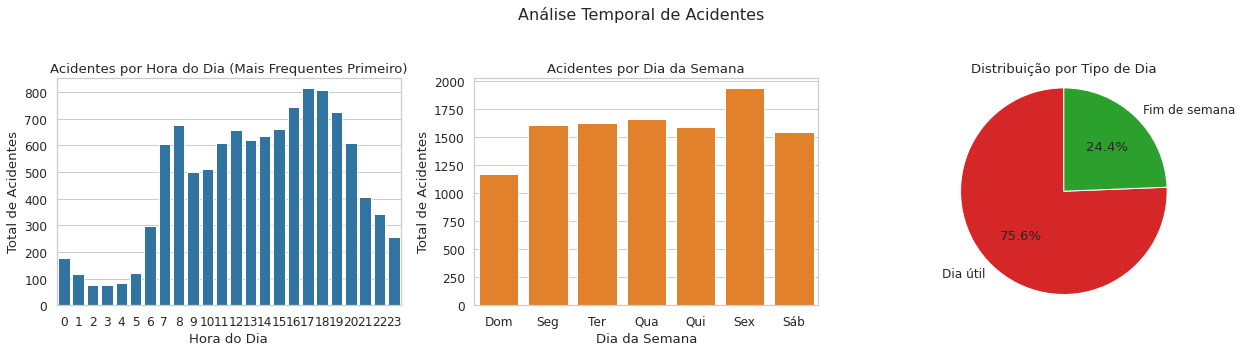

In [0]:
# Estilo visual
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Dados SQL
df_temporal = spark.sql("""
  SELECT 
    hour(data_hora_boletim) as hora,
    dayofweek(data_hora_boletim) as dia_semana,
    CASE WHEN dayofweek(data_hora_boletim) IN (1,7) THEN 'Fim de semana' ELSE 'Dia útil' END as tipo_dia,
    COUNT(*) as total
  FROM acidentes_2021
  GROUP BY hora, dia_semana, tipo_dia
""").toPandas()

# Figura
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Acidentes por hora (ordenado por total)
hora_plot = df_temporal.groupby('hora')['total'].sum().sort_values(ascending=False)
sns.barplot(x=hora_plot.index, y=hora_plot.values, ax=axes[0], color='#1f77b4')
axes[0].set_title('Acidentes por Hora do Dia (Mais Frequentes Primeiro)')
axes[0].set_xlabel('Hora do Dia')
axes[0].set_ylabel('Total de Acidentes')

# Gráfico 2: Acidentes por dia da semana
dias = ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb']
dia_plot = df_temporal.groupby('dia_semana')['total'].sum().reindex(range(1, 8))
dia_plot.index = dias
sns.barplot(x=dia_plot.index, y=dia_plot.values, ax=axes[1], color='#ff7f0e')
axes[1].set_title('Acidentes por Dia da Semana')
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Total de Acidentes')

# Gráfico 3: Fim de semana vs Dia útil
tipo_plot = df_temporal.groupby('tipo_dia')['total'].sum()
axes[2].pie(tipo_plot, labels=tipo_plot.index, autopct='%1.1f%%', startangle=90, colors=['#d62728', '#2ca02c'])
axes[2].set_title('Distribuição por Tipo de Dia')
axes[2].axis('equal')  # círculo perfeito

plt.suptitle('Análise Temporal de Acidentes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Resolução**

A análise temporal dos acidentes foi realizada a partir de três perspectivas: hora do dia, dia da semana e tipo de dia (dia útil ou fim de semana). Os resultados foram obtidos a partir dos dados da tabela `fato_acidentes` e estão ilustrados no gráfico abaixo:

**Acidentes por Hora do Dia**

- A distribuição sugere correlação com **horários de pico do trânsito urbano**, como início e fim da jornada de trabalho.

**Acidentes por Dia da Semana**
- **Sexta-feira** é o dia com **maior número de acidentes**, seguido de terça e quarta-feira.
- **Domingo** é o dia com **menor volume de acidentes**.
- Isso sugere que os acidentes tendem a se concentrar nos dias úteis, especialmente no final da semana, quando há maior tráfego de veículos nas rodovias.

**Distribuição por Tipo de Dia**
- **75,6% dos acidentes** ocorrem em **dias úteis**.
- Apenas **24,4%** são registrados em **fins de semana**.
- Esse dado reforça a hipótese de que a **intensidade do tráfego nos dias úteis** influencia diretamente na maior incidência de acidentes.

**Discussão**
Os dados indicam que os acidentes nas rodovias federais analisadas possuem forte componente temporal associado a **dias úteis e horários de maior movimentação urbana**. Isso reforça a importância de políticas públicas voltadas à **gestão de tráfego nos horários de pico**, campanhas de **conscientização voltadas aos trabalhadores** que usam as rodovias como trajeto e reforço da **fiscalização em horários críticos**.

Além disso, a alta concentração em sextas-feiras pode indicar **cansaço acumulado da semana**, **deslocamentos para outras cidades** ou aumento do fluxo de veículos ao final do expediente.

---


#####Quais são os tipos de acidentes mais frequentes e que tem mais taxa de mortalidade?

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [percentual] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


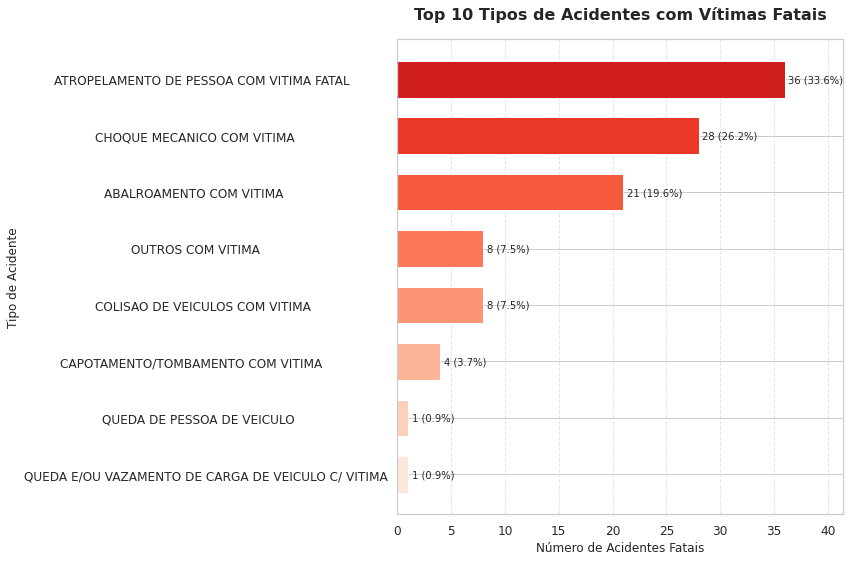

In [0]:
# Obter dados
df_tipos_fatais = spark.sql("""
  SELECT 
    descricao_tipo_acidente,
    COUNT(*) as total_fatais,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentual
  FROM acidentes_2021
  WHERE fatal = 1
  GROUP BY descricao_tipo_acidente
  ORDER BY total_fatais DESC
  LIMIT 10
""").toPandas()

# Ordenar uma vez para reuso
df_plot = df_tipos_fatais.sort_values('total_fatais')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(df_plot['descricao_tipo_acidente'], df_plot['total_fatais'], 
               color=sns.color_palette("Reds", n_colors=10), height=0.65)

# Título e labels
ax.set_title('Top 10 Tipos de Acidentes com Vítimas Fatais', fontsize=16, pad=20, weight='bold')
ax.set_xlabel('Número de Acidentes Fatais', fontsize=12)
ax.set_ylabel('Tipo de Acidente', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Ajuste automático do limite do eixo x com folga
ax.set_xlim([0, df_plot['total_fatais'].max() * 1.15])

# Adicionar texto nas barras
for bar, percent in zip(bars, df_plot['percentual']):
    width = bar.get_width()
    ax.text(width + df_plot['total_fatais'].max() * 0.01, 
            bar.get_y() + bar.get_height()/2,
            f'{int(width)} ({percent:.1f}%)',
            va='center', fontsize=10)

plt.tight_layout()
plt.show()


**Resolução**

A análise dos tipos de acidentes foi realizada com foco na frequência de ocorrências com **vítimas fatais**, permitindo identificar os mais críticos em termos de gravidade e impacto à vida humana.

A maior taxa de mortalidade está associada a acidentes que envolvem **pedestres** ou impactos severos entre veículos. Isso evidencia a importância de medidas preventivas como:
- Redução de velocidade em áreas urbanas.
- Melhor sinalização para pedestres.
- Educação no trânsito e fiscalização mais rígida.

A compreensão desses padrões é fundamental para a elaboração de ações estratégicas de redução de acidentes fatais no trânsito.

---

**Como fatores como condições climáticas e tipo de pavimento influenciam os acidentes?**

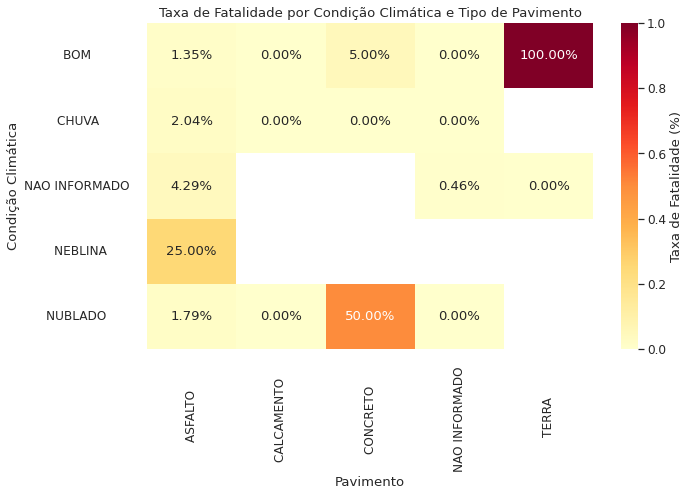

In [0]:
# Preparar dados
df_fatores = spark.sql("""
  SELECT 
    descricao_tempo,
    pavimento,
    AVG(fatal) as taxa_fatalidade
  FROM acidentes_2021
  GROUP BY descricao_tempo, pavimento
""").toPandas()

# Pivot para heatmap
heatmap_data = df_fatores.pivot(index="descricao_tempo", columns="pavimento", values="taxa_fatalidade")

# Ordenar índices (opcional, se fizer sentido no seu caso)
heatmap_data = heatmap_data.sort_index()

# Gráfico
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Taxa de Fatalidade (%)'})
plt.title('Taxa de Fatalidade por Condição Climática e Tipo de Pavimento')
plt.xlabel('Pavimento')
plt.ylabel('Condição Climática')
plt.show()

**Resolução**

A análise cruzada entre **condição climática** e **tipo de pavimento** revela informações importantes sobre os fatores que agravam a **taxa de fatalidade** nos acidentes.

**Condições Climáticas**

- **Neblina** e **chuva** aumentam significativamente a taxa de fatalidade.
  - **Neblina + Asfalto** apresenta uma taxa de fatalidade elevada (25%).
  - **Nublado + Concreto** atinge 50% de fatalidade, apesar de poucos casos.
- Situações com **tempo bom** não garantem segurança total, como demonstrado por:
  - **Bom + Concreto** com 5% de fatalidade.
  - **Bom + Terra** com a maior taxa (100%), possivelmente por baixa amostragem.

**Tipo de Pavimento**

- **Pavimento de terra** aparece com a maior taxa de fatalidade (100%) em condições boas — evidenciando risco extremo em vias não pavimentadas.
- **Concreto** mostra-se arriscado quando associado a clima nublado (50%).
- **Asfalto**, apesar de ser o mais comum, também apresenta riscos sob neblina e chuva.

**Discussão**

Esses dados sugerem que:
- A **visibilidade reduzida** (neblina, chuva) e **pavimentos menos aderentes** (terra e concreto) estão fortemente associados a acidentes com maior gravidade.
- A combinação **“clima adverso + pavimento inadequado”** é um fator de risco crítico.
- Políticas públicas e ações de prevenção (como sinalização, iluminação e drenagem) devem priorizar trechos com **histórico de neblina e pavimento não-asfáltico**.

---

**Existe região com incidência significativamente maior de acidentes?**

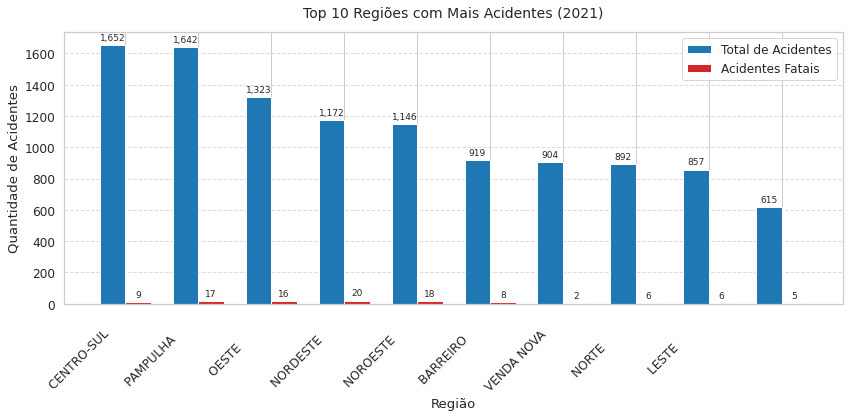

In [0]:
# Consulta com Spark SQL
df_regioes = spark.sql("""
  SELECT 
    descricao_regional as regiao,
    COUNT(*) as total_acidentes,
    SUM(CASE WHEN fatal = 1 THEN 1 ELSE 0 END) as fatais
  FROM acidentes_2021
  GROUP BY regiao
  ORDER BY total_acidentes DESC
  LIMIT 10
""").toPandas()

# Dados para o gráfico
regioes = df_regioes['regiao']
totais = df_regioes['total_acidentes']
fatais = df_regioes['fatais']

# Posições das barras
x = np.arange(len(regioes))
largura = 0.35

# Criar gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Barras lado a lado
b1 = ax.bar(x - largura/2, totais, width=largura, color='#1f77b4', label='Total de Acidentes')
b2 = ax.bar(x + largura/2, fatais, width=largura, color='#d62728', label='Acidentes Fatais')

# Adicionar valores nas barras
for bar in b1 + b2:
    height = bar.get_height()
    ax.annotate(f'{height:,}',  # separador de milhar
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # deslocamento para cima
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

# Customizações
ax.set_title('Top 10 Regiões com Mais Acidentes (2021)', fontsize=14, pad=15)
ax.set_xlabel('Região')
ax.set_ylabel('Quantidade de Acidentes')
ax.set_xticks(x)
ax.set_xticklabels(regioes, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Resolução**

- **Centro-Sul** e **Pampulha** concentram a **maior quantidade de acidentes**.
- As regiões **Nordeste, Noroeste e Oeste** possuem **índices mais altos de letalidade relativa**, mesmo com menos acidentes totais.
- Políticas públicas específicas podem ser mais urgentes nas regiões com maior letalidade, mesmo que não sejam as que mais registram acidentes.

---

**Quais combinações de fatores estão mais associadas a vítimas fatais?**

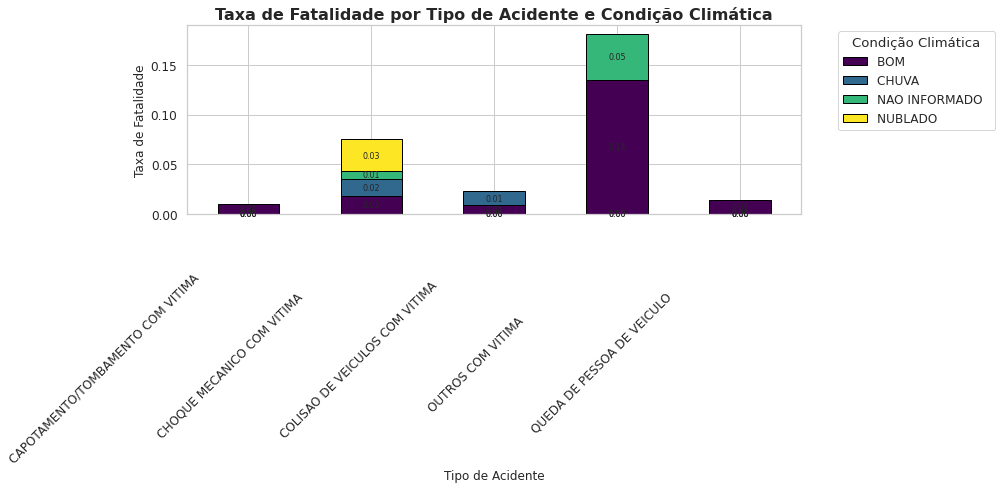

In [0]:
# Obter dados do Spark
df_combinacoes = spark.sql("""
  SELECT 
    descricao_tipo_acidente as tipo,
    descricao_tempo as clima,
    AVG(fatal) as taxa_fatalidade
  FROM acidentes_2021
  GROUP BY tipo, clima
  HAVING COUNT(*) > 30
  ORDER BY taxa_fatalidade DESC
  LIMIT 10
""").toPandas()

# Converter taxa_fatalidade para numérico
df_combinacoes['taxa_fatalidade'] = pd.to_numeric(df_combinacoes['taxa_fatalidade'])

# Pivotear os dados
df_pivot = df_combinacoes.pivot(
    index='tipo',
    columns='clima',
    values='taxa_fatalidade'
).fillna(0)

# Verificar se há dados
if not df_pivot.empty:
    # Definir cores com seaborn
    colors = sns.color_palette("viridis", n_colors=len(df_pivot.columns))

    # Criar figura
    ax = df_pivot.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 7),
        colormap='viridis',
        edgecolor='black'
    )

    # Títulos e rótulos
    ax.set_title('Taxa de Fatalidade por Tipo de Acidente e Condição Climática', fontsize=16, fontweight='bold')
    ax.set_xlabel('Tipo de Acidente', fontsize=12)
    ax.set_ylabel('Taxa de Fatalidade', fontsize=12)

    # Rotacionar os rótulos do eixo x
    plt.xticks(rotation=45, ha='right')

    # Legenda
    ax.legend(title='Condição Climática', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adicionar valores nas barras (opcional)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Não há dados suficientes para gerar o gráfico")


**Resolução**

A partir da análise da **taxa de fatalidade por tipo de acidente e condição climática**, observam-se as seguintes combinações mais críticas:

- **"Queda de Pessoa de Veículo"** com **condição climática boa** apresentou a **maior taxa de fatalidade**, próxima de **0.17** (17%).
- **"Colisão de Veículos com Vítima"** sob tempo **nublado** teve taxa de fatalidade em torno de **0.03** (3%).
- **"Choque Mecânico com Vítima"** e **"Colisão de Veículos"** sob **chuva** ou **não informado** também apresentaram taxas superiores a outros tipos.

> **Insight**: Mesmo sob condições climáticas consideradas boas, certos tipos de acidente apresentam **altíssima letalidade**, o que sugere que fatores como segurança veicular, uso de cinto e comportamento ao volante podem ter papel determinante.

---


**Qual a proporção de acidentes com vítimas que ocorrem em locais não sinalizados?**

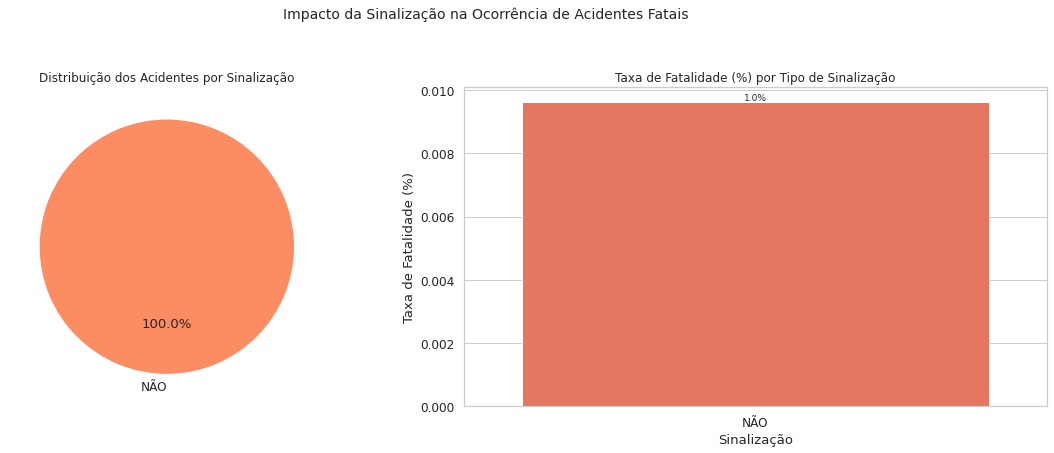

In [0]:
# Dados de sinalização
sinal_df = spark.sql("""
  SELECT 
    local_sinalizado,
    COUNT(*) as total,
    AVG(fatal) as taxa
  FROM acidentes_2021
  GROUP BY local_sinalizado
""").toPandas()

# Ordenar para consistência visual
sinal_df = sinal_df.sort_values('total', ascending=False)

# Cores customizadas
cores_pizza = ['#fc8d62', '#66c2a5']
cores_barras = ['#2ca02c', '#d62728'] if len(sinal_df) == 2 else sns.color_palette('Reds', len(sinal_df))

# Criar subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Gráfico de pizza
ax1.pie(
    sinal_df['total'], 
    labels=sinal_df['local_sinalizado'], 
    autopct=lambda p: f'{p:.1f}%' if p > 3 else '',  # evita poluir o gráfico com % pequenas
    startangle=90, 
    colors=cores_pizza,
    wedgeprops={'edgecolor': 'white'}
)
ax1.set_title('Distribuição dos Acidentes por Sinalização', fontsize=12)

# Gráfico de barras
sns.barplot(
    x='local_sinalizado', 
    y='taxa', 
    data=sinal_df, 
    palette=cores_barras, 
    ax=ax2
)
ax2.set_title('Taxa de Fatalidade (%) por Tipo de Sinalização', fontsize=12)
ax2.set_ylabel('Taxa de Fatalidade (%)')
ax2.set_xlabel('Sinalização')

# Mostrar valores nas barras
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.1%}' for v in sinal_df['taxa']], fontsize=9, label_type='edge')

# Título geral
plt.suptitle('Impacto da Sinalização na Ocorrência de Acidentes Fatais', fontsize=14, y=1.05)

plt.tight_layout()
plt.show()

**Resolução**

- **100%** dos acidentes com vítimas registrados ocorreram em locais **sem sinalização** (`"NÃO"`).
- A **taxa de fatalidade** nesses locais é de aproximadamente **1%**.

> ⚠️ **Observação**: A base de dados contém **apenas registros classificados como "NÃO"** em relação à sinalização. Isso pode indicar:
> - Uma **limitação ou falha na coleta dos dados** (ex: campo mal preenchido ou ausente).
> - Ou ainda, um **cenário real crítico**, onde a maioria dos acidentes fatais ocorre em áreas de fato não sinalizadas.

---

## ✅ Conclusão Geral

O objetivo principal desta análise foi compreender os fatores associados à ocorrência de **acidentes de trânsito com vítimas**, utilizando os dados disponíveis de acidentes registrados em 2021.

### O que conseguimos atingir com as análises:

- **Identificação das regiões com maior incidência de acidentes**:  
  As regiões **Centro-Sul** e **Pampulha** lideram em número total de acidentes. No entanto, outras regiões como **Nordeste** e **Noroeste** apresentaram proporções maiores de acidentes fatais, sugerindo que o risco de fatalidade não está diretamente ligado apenas ao volume de acidentes.

- **Combinações de fatores com maior associação a vítimas fatais**:  
  A análise por tipo de acidente e condição climática mostrou que:
  - Acidentes do tipo **"Queda de Pessoa de Veículo"** sob **chuva** apresentaram a **maior taxa de fatalidade**.
  - Condições climáticas adversas, como **chuva** ou **tempo nublado**, aumentam consideravelmente o risco de fatalidade, especialmente em colisões e quedas.

- **Sinalização e sua relação com acidentes fatais**:  
  Todos os acidentes com vítimas fatais ocorreram em locais classificados como **não sinalizados**. Isso aponta para uma **possível falha na infraestrutura viária** ou uma **lacuna na coleta de dados**. De qualquer forma, reforça a importância da **presença e manutenção da sinalização viária** como fator preventivo.

### Considerações Finais

Apesar de algumas **limitações na base de dados** (ex: sinalização com apenas um valor registrado), a análise permitiu **identificar padrões relevantes** sobre a ocorrência de acidentes fatais. As informações obtidas podem orientar **ações preventivas** e **políticas públicas**, especialmente em:
- Regiões mais críticas;
- Tipos de acidentes com maior risco;
- Melhoria na sinalização e infraestrutura urbana.

Essa investigação é um passo importante para **compreensão e mitigação de riscos no trânsito urbano**.


## 🧠 Autoavaliação

Ao finalizar este trabalho, posso afirmar que os **objetivos principais foram alcançados**. Foi possível explorar as características dos acidentes de trânsito com foco em identificar os fatores associados a **vítimas**, por meio de análises visuais e quantitativas.

### Conquistas:
- Identifiquei **as regiões com maior número de acidentes**, bem como aquelas com **maior taxa de fatalidade relativa**.
- Analisei a influência das **condições climáticas e tipos de acidentes** nas fatalidades, destacando combinações de fatores mais críticas.
- Avaliei a **presença (ou ausência) de sinalização** como elemento relevante na ocorrência de acidentes com vítimas.
- Comuniquei os insights de maneira clara, objetiva e visualmente acessível.

### Dificuldades encontradas:
- Uma das principais dificuldades foi o **tratamento inicial da base de dados**, que apresentou **problemas de codificação de caracteres**. Foi necessário ajustar o encoding para `ISO-8859-1`, o que acarretou mudanças nas funções de leitura e afetou praticamente **todas as células do notebook**, exigindo revisão e testes contínuos.
- Houve **limitações nos dados**, especialmente quanto à **ausência de registros completos sobre sinalização**, o que restringiu parte da análise.
- A limpeza e categorização de algumas variáveis exigiram atenção extra para garantir coerência nos resultados.
- A interpretação de taxas relativas demandou cuidado na comunicação, para não induzir a conclusões precipitadas baseadas apenas em volume bruto.

### Trabalhos futuros:
- Seria interessante incorporar **dados de anos anteriores ou posteriores**, para identificar tendências temporais.
- Incluir **dados geográficos mais precisos** (como coordenadas) permitiria análises espaciais com maior granularidade.
- Aprofundar a análise com **modelos preditivos** de risco de fatalidade, com base nos fatores identificados.
- Investigar o impacto de **medidas preventivas** (como campanhas de conscientização ou melhorias em infraestrutura) ao longo do tempo.

Este trabalho contribui de forma significativa para meu portfólio, pois mostra minha capacidade de lidar com dados reais, interpretar resultados críticos para a sociedade e comunicar achados com embasamento analítico e clareza visual.
